## Using LSTM layer for seq 2 seq task of our
LSTM has 3 important parameters
- Units: Positive integer, dimensionality of output space
This represents the dimension of the output vector.

- return_sequences: Boolean, whether to return the last output. In the output sequence or the full sequence. Default is false.
- return_state: Boolean, whether to return the last state in addition to the output.
These determines what the LSTM layer outputs. LSTM can return 4 different sets of results/states accordint to the given parameters.

1. **Default**: Last Hidden State
2. **return_sequence=True** : All Hidden States
3. **return_state=True** : Last Hidden State + Last Hidden State(again) + Last Cell State
4. **return_sequences=True+return_state=True** : All Hidden States + Last Hidden State + Last Cell State (of timestep)

#### Dataset prepare

In [13]:
import numpy as np

In [2]:
def generate_sequence(length, n_unique):
	return [np.random.randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

#### Model Configuration

In [3]:
N_TIMESTEPS = 4
N_FEATURES = 10
TRAIN_SIZE = 2000
TEST_SIZE = 200
LATENT_DIM = 16

## 1. LSTM with default output
- Last Hidden State will be output
- The size of the output vector will be as LATENT DIM (16)

`**RepeatVector Layer**`: This layer repeats the input n times. It make a copy of LSTM output as the number of n_timesteps so that Dense layer can have an output shape of (batch_size, 4, 16)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RepeatVector

#### Concept: Repeat Vector
Repeat Vector layer takes a 2d input of shape (batch_size, features) and repeats it along a new time axis.

Input : (batch_size, features) Output: (batch_size, n_repeats, features)

In [8]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RepeatVector, Input

i_features = 5
n_repeats = 3

inputs_ = Input(shape=(i_features, ))
repeats = RepeatVector(n_repeats)(inputs_)
model_ = Model(inputs=inputs_, outputs=repeats)

model_.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 5)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
sample_input = np.array([[1,2,3,4,5]])
output = model_.predict(sample_input)

print(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
[[[1. 2. 3. 4. 5.]
  [1. 2. 3. 4. 5.]
  [1. 2. 3. 4. 5.]]]


In [12]:
model_0 = Sequential()
model_0.add(Input(shape=(N_TIMESTEPS, N_FEATURES))) # (4, 10) i.e for 4 seq length of 10 one hot encoded features
model_0.add(LSTM(LATENT_DIM))
model_0.add(RepeatVector(N_TIMESTEPS)) # repeat the input N_TIMESTEPS time
model_0.add(Dense(N_FEATURES, activation="softmax"))

In [22]:
model_0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 10)          │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,898 (7.41 KB)

 Trainable params: 1,898 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
import matplotlib.pyplot as plt

def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=100, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	print('some examples...')
	for _ in range(10):
		X,y = get_reversed_pairs(N_TIMESTEPS, N_FEATURES)
		yhat = model.predict(X, verbose=0)
		print('Input',one_hot_decode(X[0]),
					'Expected:', one_hot_decode(y[0]), 
						'Predicted', one_hot_decode(yhat[0]),
							'', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )
	


In [20]:
X_train, y_train, X_test, 	y_test = create_dataset(TRAIN_SIZE, TEST_SIZE, N_TIMESTEPS, N_FEATURES)

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 39.825, Test: 39.125


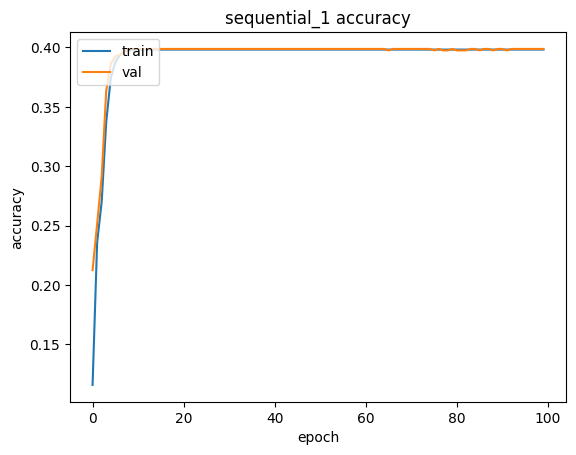

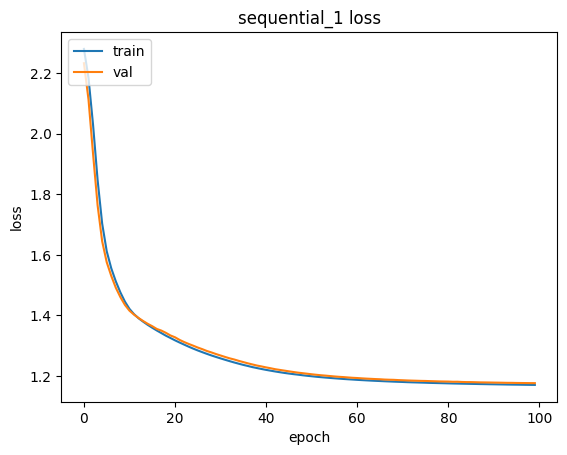

some examples...
Input [8, 1, 8, 0] Expected: [0, 8, 1, 8] Predicted [8, 8, 8, 8]  False
Input [4, 3, 1, 8] Expected: [8, 1, 3, 4] Predicted [3, 3, 3, 3]  False
Input [0, 7, 2, 1] Expected: [1, 2, 7, 0] Predicted [7, 7, 7, 7]  False
Input [4, 6, 4, 8] Expected: [8, 4, 6, 4] Predicted [4, 4, 4, 4]  False
Input [5, 0, 1, 4] Expected: [4, 1, 0, 5] Predicted [1, 1, 1, 1]  False
Input [6, 5, 6, 7] Expected: [7, 6, 5, 6] Predicted [6, 6, 6, 6]  False
Input [0, 8, 5, 4] Expected: [4, 5, 8, 0] Predicted [8, 8, 8, 8]  False
Input [7, 7, 7, 2] Expected: [2, 7, 7, 7] Predicted [7, 7, 7, 7]  False
Input [5, 1, 4, 2] Expected: [2, 4, 1, 5] Predicted [5, 5, 5, 5]  False
Input [1, 8, 2, 6] Expected: [6, 2, 8, 1] Predicted [1, 1, 1, 1]  False


In [23]:
train_test(model_0, 
           X_train, y_train , X_test, y_test, 
           verbose=0)

In order to increment a model capacity we could increment:

- Number of units
- Number of layers
- Number of epoch
- Number of train dataset

### 2. Multiple LSTM Layers
We can stack multiple lstm layers by connecting the output state from one to another.

In [24]:
model_1 = Sequential()
model_1.add(Input(shape=(N_TIMESTEPS, N_FEATURES))) # (4, 10) i.e for 4 seq length of 10 one hot encoded features

model_1.add(LSTM(LATENT_DIM))
model_1.add(RepeatVector(N_TIMESTEPS)) # repeat the input N_TIMESTEPS time

model_1.add(LSTM(LATENT_DIM))
model_1.add(RepeatVector(N_TIMESTEPS)) # repeat the input N_TIMESTEPS time

model_1.add(Dense(N_FEATURES, activation="softmax"))

In [25]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4, 10)          │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 39.825, Test: 39.125


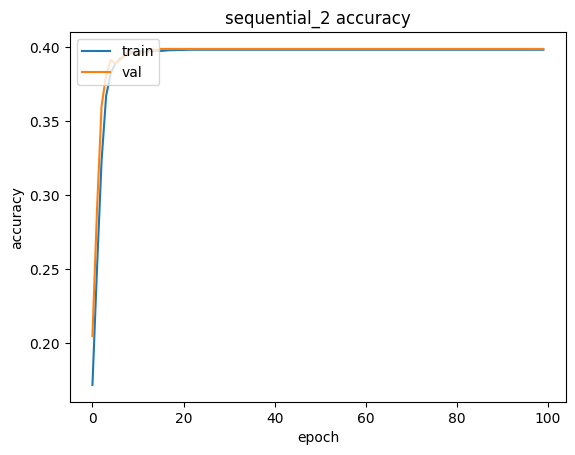

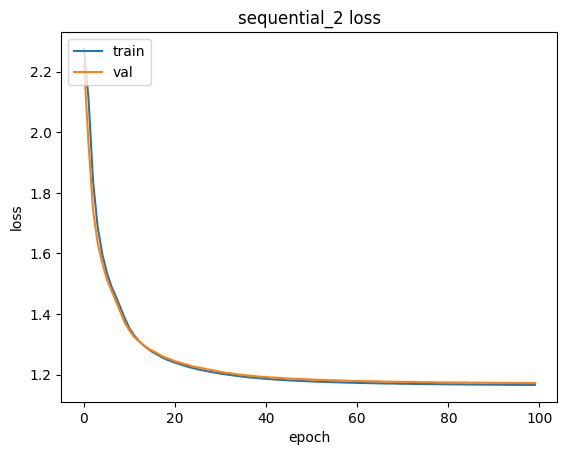

some examples...
Input [3, 2, 5, 3] Expected: [3, 5, 2, 3] Predicted [3, 3, 3, 3]  False
Input [3, 7, 8, 0] Expected: [0, 8, 7, 3] Predicted [8, 8, 8, 8]  False
Input [0, 2, 0, 8] Expected: [8, 0, 2, 0] Predicted [0, 0, 0, 0]  False
Input [3, 0, 4, 3] Expected: [3, 4, 0, 3] Predicted [3, 3, 3, 3]  False
Input [7, 5, 2, 3] Expected: [3, 2, 5, 7] Predicted [5, 5, 5, 5]  False
Input [1, 4, 6, 6] Expected: [6, 6, 4, 1] Predicted [6, 6, 6, 6]  False
Input [1, 7, 2, 6] Expected: [6, 2, 7, 1] Predicted [7, 7, 7, 7]  False
Input [2, 0, 2, 3] Expected: [3, 2, 0, 2] Predicted [2, 2, 2, 2]  False
Input [3, 4, 5, 3] Expected: [3, 5, 4, 3] Predicted [3, 3, 3, 3]  False
Input [6, 3, 6, 6] Expected: [6, 6, 3, 6] Predicted [6, 6, 6, 6]  False


In [28]:
train_test(
    model_1, X_train, y_train, X_test, y_test, verbose=0
)

## 3. Multiple LSTM layers by connection with return sequences
In last model, we connect the model by the default output of one LSTM to another. As the second option we can create a model containing LSTM layer which are connected to each other by return sequences i.e all hidden states at each timesteps.

We let the second LSTM layer return all hidden states as input to dense layer and to connect the LSTM to Dense layer we use **TimeDistributed** layer so that for each timestep of the second LSTM output dense layer will generate one prediction.

#### TimeDistributed Concept:
The `TimeDistributed` layer applies a given layer to each timestep of a sequence input.

- Input Shape: (batch_size, timesteps, features)
- The TimeDistributed layer applies the specified layer independently to each timestep in the input

In [30]:
from tensorflow.keras.layers import Dense, TimeDistributed, Input
from tensorflow.keras.models import Model

timesteps_ = 4
features_ = 5
output_units_ = 3

inputs_ = Input(shape=(timesteps_, features_))
dense_layer = TimeDistributed(Dense(output_units_))

model_ = Model(inputs=inputs_, outputs=dense_layer(inputs_))

model_.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 3)           │            18 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18 (72.00 B)

 Trainable params: 18 (72.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
sample_input = np.random.rand(1, timesteps_, features_)
output = model_.predict(sample_input)

print(f"sample input : {sample_input}\n")
print(f"input shape: {sample_input.shape}\n")
print(f"output after time distributed: {output}\n")
print(f"output shape: {output.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sample input : [[[0.83412196 0.96799508 0.61495939 0.04346192 0.80798125]
  [0.16196743 0.39982852 0.65664924 0.79012104 0.58475949]
  [0.39057238 0.37760438 0.23556024 0.60385287 0.39709763]
  [0.34731474 0.10590626 0.75788669 0.65501726 0.33997701]]]

input shape: (1, 4, 5)

output after time distributed: [[[-0.6234547   0.4527377  -1.3244853 ]
  [ 0.16769558 -0.36757064 -0.09251139]
  [-0.2515224  -0.25095376 -0.32683602]
  [ 0.19479617 -0.11511642 -0.02786625]]]

output shape: (1, 4, 3)


In [35]:
model_3 = Sequential()
model_3.add(Input(shape=(N_TIMESTEPS, N_FEATURES)))

model_3.add(LSTM(LATENT_DIM, return_sequences=True))

model_3.add(LSTM(LATENT_DIM, return_sequences=True))

model_3.add(TimeDistributed(Dense(N_FEATURES, activation="softmax")))

In [36]:
model_3.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [37]:
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 4, 16)          │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4, 16)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 10)          │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 56.187, Test: 54.625


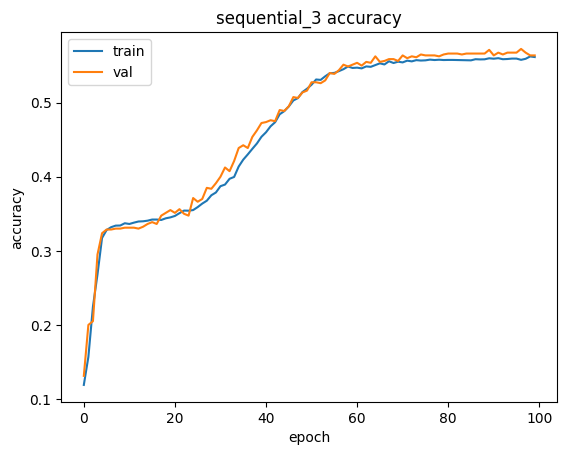

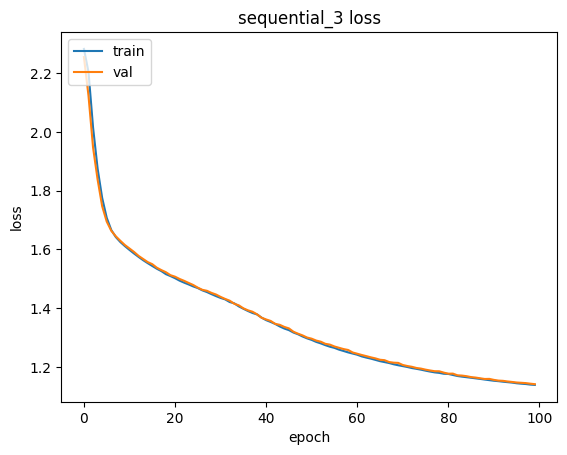

some examples...
Input [6, 1, 2, 1] Expected: [1, 2, 1, 6] Predicted [5, 6, 1, 6]  False
Input [6, 4, 7, 1] Expected: [1, 7, 4, 6] Predicted [5, 4, 4, 6]  False
Input [1, 2, 7, 7] Expected: [7, 7, 2, 1] Predicted [5, 2, 2, 1]  False
Input [1, 5, 4, 2] Expected: [2, 4, 5, 1] Predicted [5, 5, 5, 1]  False
Input [7, 8, 5, 0] Expected: [0, 5, 8, 7] Predicted [5, 8, 8, 7]  False
Input [6, 8, 4, 3] Expected: [3, 4, 8, 6] Predicted [5, 8, 8, 6]  False
Input [6, 5, 3, 1] Expected: [1, 3, 5, 6] Predicted [5, 5, 5, 6]  False
Input [3, 7, 4, 4] Expected: [4, 4, 7, 3] Predicted [5, 7, 7, 3]  False
Input [6, 2, 8, 0] Expected: [0, 8, 2, 6] Predicted [5, 2, 2, 6]  False
Input [7, 3, 7, 7] Expected: [7, 7, 3, 7] Predicted [5, 3, 3, 7]  False


In [38]:
train_test(
    model_3, X_train, y_train, X_test, y_test, verbose=0
)

## 4. Multiple LSTM with return state

when return state is true LSTM will output
- LSTM output: (Last Hidden State)
- Last Hidden State: (again)
- Last Cell State: (Cell State)

We use second and third outputs of the First LSTM layer to initialize the next LSTM layers state.

In [40]:
input = Input(shape=(N_TIMESTEPS, N_FEATURES))

lstm_1 = LSTM(LATENT_DIM, return_state=True)
lstm_output_1, state_h_1, state_c_1 = lstm_1(input)
states_1 = [state_h_1, state_c_1]

repeat = RepeatVector(N_TIMESTEPS)
lstm_output_1 = repeat(lstm_output_1) # [batchsize, features] : [batchsize, timesteps, features]

lstm_2 = LSTM(LATENT_DIM, return_sequences=True)
all_state_h = lstm_2(lstm_output_1, initial_state=states_1)

dense = TimeDistributed(Dense(N_FEATURES, activation="softmax"))
output = dense(all_state_h)

model_4 = Model(input, output)

In [41]:
model_4.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 4, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 16),      │      1,728 │ input_layer_10[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 4, 16)     │          0 │ lstm_8[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 4, 16)     │      2,112 │ repeat_vector_9[… │
│                     │                   │            │ lstm_8[0][1],     │
│                     │                   │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 4, 10)     │        170 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 97.275, Test: 96.000


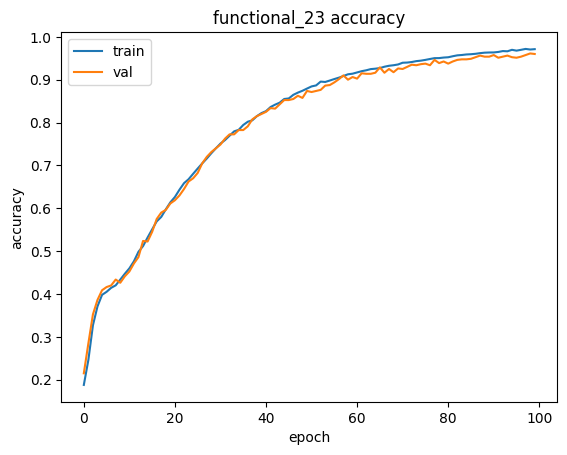

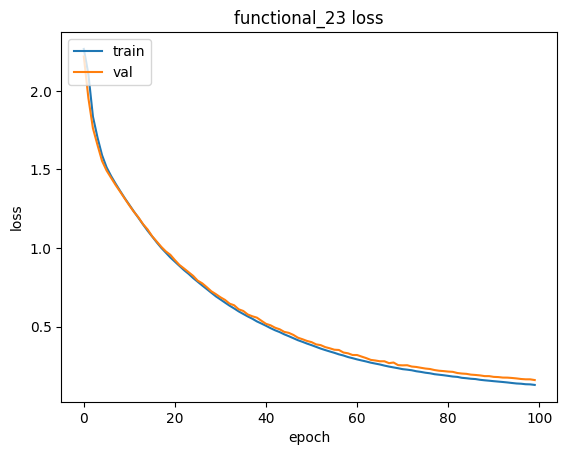

some examples...
Input [8, 2, 7, 6] Expected: [6, 7, 2, 8] Predicted [6, 7, 2, 8]  True
Input [2, 0, 0, 5] Expected: [5, 0, 0, 2] Predicted [5, 0, 0, 1]  False
Input [0, 7, 6, 1] Expected: [1, 6, 7, 0] Predicted [1, 6, 7, 0]  True
Input [1, 4, 0, 6] Expected: [6, 0, 4, 1] Predicted [6, 0, 4, 1]  True
Input [1, 3, 1, 7] Expected: [7, 1, 3, 1] Predicted [7, 1, 3, 1]  True
Input [2, 5, 3, 3] Expected: [3, 3, 5, 2] Predicted [3, 3, 5, 2]  True
Input [1, 2, 2, 0] Expected: [0, 2, 2, 1] Predicted [0, 2, 2, 1]  True
Input [0, 5, 7, 0] Expected: [0, 7, 5, 0] Predicted [0, 7, 5, 0]  True
Input [8, 8, 1, 7] Expected: [7, 1, 8, 8] Predicted [7, 1, 8, 8]  True
Input [1, 0, 4, 3] Expected: [3, 4, 0, 1] Predicted [3, 4, 0, 1]  True


In [44]:
train_test(model_4, X_train, y_train , X_test, 	y_test)

## 5. Multiple LSTM with return sequence and return state

In [46]:
input = Input(shape=(N_TIMESTEPS, N_FEATURES))

lstm_1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
lstm_output_1, state_h_1, state_c_1 = lstm_1(input)
# no need for repeat vector here because we are using return_sequences=True so that the output is already in the shape of [batchsize, timesteps, features]
states_1 = [state_h_1, state_c_1]

lstm_2 = LSTM(LATENT_DIM, return_sequences=True)
lstm_output_2 = lstm_2(lstm_output_1, initial_state=states_1)

dense = TimeDistributed(Dense(N_FEATURES, activation="softmax"))
output = dense(lstm_output_2)

model_5 = Model(input, output)

model_5.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 4, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 4, 16),   │      1,728 │ input_layer_12[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 4, 16)     │      2,112 │ lstm_12[0][0],    │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 4, 10)     │        170 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 99.950, Test: 99.500


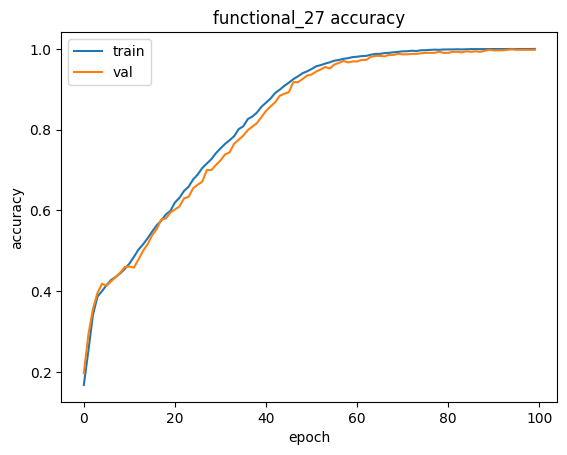

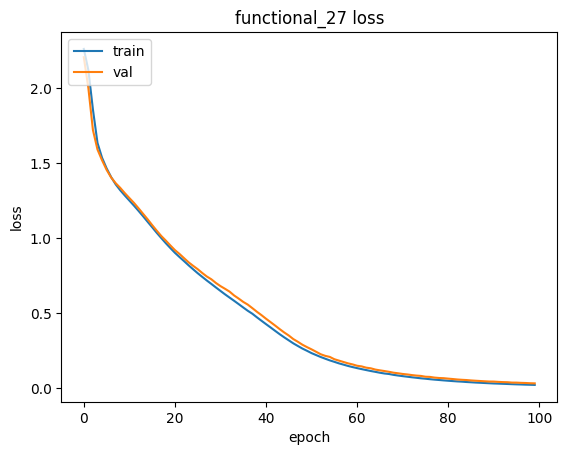

some examples...
Input [0, 7, 6, 2] Expected: [2, 6, 7, 0] Predicted [2, 6, 7, 0]  True
Input [0, 1, 3, 0] Expected: [0, 3, 1, 0] Predicted [0, 3, 1, 0]  True
Input [2, 2, 3, 6] Expected: [6, 3, 2, 2] Predicted [6, 3, 2, 2]  True
Input [7, 5, 4, 0] Expected: [0, 4, 5, 7] Predicted [0, 4, 5, 7]  True
Input [3, 7, 0, 0] Expected: [0, 0, 7, 3] Predicted [0, 0, 7, 3]  True
Input [2, 6, 0, 0] Expected: [0, 0, 6, 2] Predicted [0, 0, 6, 2]  True
Input [1, 5, 6, 5] Expected: [5, 6, 5, 1] Predicted [5, 6, 5, 1]  True
Input [1, 1, 2, 1] Expected: [1, 2, 1, 1] Predicted [1, 2, 1, 1]  True
Input [5, 3, 2, 5] Expected: [5, 2, 3, 5] Predicted [5, 2, 3, 5]  True
Input [5, 7, 2, 6] Expected: [6, 2, 7, 5] Predicted [6, 2, 7, 5]  True


In [49]:
train_test(model_5, X_train, y_train , X_test, 	y_test)

# Discussion

We get around 99 percent accuracy on our recent model with input_sequence size of 4 but if we increase the size to 8 or 16 our accuracy significantly decreases and cannot handle longer sequences.

## How to handle Longer Sequences?
Increment the model capacity like increasing dimension, training data, multiple layers, training epoch etc.

But LSTM can not handle the sequence which it need to memorize for longer data.

## Handling variable length input and output
In our case we just had the same input and output sequence size i.e just for reversing [1, 2, 3, 4] : [4, 3, 2, 1] but what if we need to make model that would just output the unique numbers only like e.g [1, 1, 2, 4, 3, 1] : [1, 2, 3, 4] here we may have variable length input and variable output. A common example would be **Machine Translation**.

For such case we can use **Padding** to make sequence length equal.

## A better solution
We can use `Encoder-Decoder` architecture to better handle such scenario.